# Klasifikasi Citra Penyakit Radang Paru-Paru dan Paru Paru Terindikasi COVID19 Menggunakan Metode CNN

Link Kaggle : https://www.kaggle.com/prashant268/chest-xray-covid19-pneumonia

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/ML/Tugas_Besar/Modul_3"

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/ML/Tugas_Besar/Modul_3

/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/ML/Tugas_Besar/Modul_3


In [ ]:
!ls

best_model.h5  Data  dataset  datasplit  kaggle.json


In [ ]:
#! kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia

100% 2.05G/2.06G [00:41<00:00, 73.8MB/s]
100% 2.06G/2.06G [00:41<00:00, 53.5MB/s]


In [ ]:
#! unzip \*.zip &> /dev/null && rm *.zip

In [ ]:
!mkdir covid

In [ ]:
!mkdir normal

In [ ]:
!mkdir pneumonia

In [ ]:
!ls Data/

test  train


In [ ]:
!mv Data/test/COVID19/*.jpg covid/

In [ ]:
!mv Data/test/PNEUMONIA/*.jpg pneumonia/

In [ ]:
!mv Data/test/NORMAL/*.jpg normal/

In [ ]:
!mv Data/train/COVID19/*.jpg covid/

In [ ]:
!mv Data/train/PNEUMONIA/*.jpg pneumonia/

In [ ]:
!mv Data/train/NORMAL/*.jpg normal/

In [ ]:
!ls

covid  Data  kaggle.json  normal  pneumonia


In [ ]:
!mkdir dataset

In [ ]:
!mv pneumonia covid normal dataset

In [ ]:
!ls dataset

covid  normal  pneumonia


# Splitting Data 1 (Skenario = 0.7, 0.2, 0.1)

In [ ]:
#pip install split-folders

In [ ]:
#!mkdir datasplit

In [ ]:
data = "/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/ML/Tugas_Besar/Modul_3/dataset"
split = "/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/ML/Tugas_Besar/Modul_3/datasplit"

In [ ]:
#import splitfolders
#splitfolders.ratio(data, output=split, seed=1337, ratio=(.7,.2,.1),group_prefix=None)

Copying files: 6432 files [02:12, 48.49 files/s]


In [ ]:
!ls datasplit

test  train  val


In [ ]:
train_path = "/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/ML/Tugas_Besar/Modul_3/datasplit/train"
val_path = "/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/ML/Tugas_Besar/Modul_3/datasplit/val"
test_path = "/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/ML/Tugas_Besar/Modul_3/datasplit/test"

#Preprocessing (Skenario 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
Batch_size=32
augmen_gen = ImageDataGenerator(rescale=1. / 255,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = augmen_gen.flow_from_directory(
    train_path,
    class_mode = 'categorical',
    shuffle=False,
    target_size = (150,150),
    batch_size=Batch_size,
    color_mode ='rgb'
)

val_gen = augmen_gen.flow_from_directory(
    val_path,
    class_mode = 'categorical',
    shuffle=False,
    target_size = (150,150),
    batch_size=Batch_size,
    color_mode ='rgb'
)

test_gen = augmen_gen.flow_from_directory(
    test_path,
    class_mode = 'categorical',
    shuffle=False,
    target_size = (150,150),
    batch_size=Batch_size,
    color_mode ='rgb',
)

Found 4502 images belonging to 3 classes.
Found 1285 images belonging to 3 classes.
Found 645 images belonging to 3 classes.


# Modelling & Plotting (Skenario 3)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, AveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import time

In [ ]:
model = Sequential()

model.add(InputLayer(input_shape=[150,150,3]))
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 19, 19, 128)      0

In [ ]:
best_model1_path = 'best1_model.h5'
checkpoint_callback = ModelCheckpoint(best_model1_path,
                                     monitor='val_accuracy',
                                     save_best_only=True,
                                     verbose=1)
reduce_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=0.000003, verbose=1)
callbacks_list = [checkpoint_callback, reduce_callback]

In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr=0.00015),
             metrics='accuracy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
start = time.time()
model_1 = model.fit_generator(train_gen, epochs=20, validation_data=val_gen, validation_steps = 4, verbose=1, callbacks=[callbacks_list])

End = time.time()
print ("training time: ", End-start,"s")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
141/141 [==============================] - ETA: 0s - loss: 1.1954 - accuracy: 0.6428 
Epoch 00001: val_accuracy improved from -inf to 0.64062, saving model to best1_model.h5
141/141 [==============================] - 3466s 25s/step - loss: 1.1954 - accuracy: 0.6428 - val_loss: 0.9086 - val_accuracy: 0.6406 - lr: 1.5000e-04
Epoch 2/20
141/141 [==============================] - ETA: 0s - loss: 0.5184 - accuracy: 0.8012
Epoch 00002: val_accuracy improved from 0.64062 to 0.71875, saving model to best1_model.h5
141/141 [==============================] - 155s 1s/step - loss: 0.5184 - accuracy: 0.8012 - val_loss: 0.6994 - val_accuracy: 0.7188 - lr: 1.5000e-04
Epoch 3/20
141/141 [==============================] - ETA: 0s - loss: 0.3763 - accuracy: 0.8558
Epoch 00003: val_accuracy did not improve from 0.71875
141/141 [==============================] - 152s 1s/step - loss: 0.3763 - accuracy: 0.8558 - val_loss: 0.9278 - val_accuracy: 0.5547 - lr: 1.5000e-04
Epoch 4/20
141/141 [========

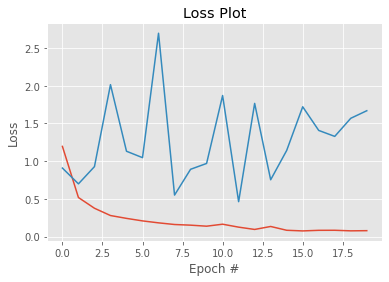

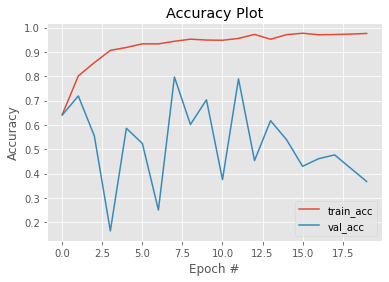

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

plt.plot(np.arange(0, 20), model_1.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), model_1.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

plt.plot(np.arange(0, 20), model_1.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), model_1.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

model.load_weights(best_model1_path)
pred = model.predict(test_gen)
predictions = np.argmax(pred, axis = 1)
#labels = (pred > 0.5).astype(np.int)
print(classification_report(test_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.70      0.90      0.79        58
           1       0.85      0.11      0.19       159
           2       0.75      0.96      0.84       428

    accuracy                           0.75       645
   macro avg       0.77      0.66      0.61       645
weighted avg       0.77      0.75      0.68       645



# Modelling & Plotting (Skenario 4)

In [ ]:
model2 = Sequential()

model2.add(InputLayer(input_shape=[150,150,3]))
model2.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=2, padding='same'))
model2.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=2, padding='same'))
model2.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=2, padding='same'))
model2.add(Dropout(0.25))
model2.add(Flatten())

# Fully Connected Layer
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(3, activation='softmax'))

In [ ]:
print(model2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 75, 75, 64)       256       
 hNormalization)                                                 
                                                      

In [ ]:
model2.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr=0.000015),
             metrics='accuracy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_2 = model2.fit_generator(train_gen, epochs=50, validation_data=val_gen, validation_steps = 4, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/50
141/141 [==============================] - 149s 1s/step - loss: 1.3595 - accuracy: 0.6368 - val_loss: 1.1128 - val_accuracy: 0.0859
Epoch 2/50
141/141 [==============================] - 147s 1s/step - loss: 0.5278 - accuracy: 0.8008 - val_loss: 2.8140 - val_accuracy: 0.1172
Epoch 3/50
141/141 [==============================] - 146s 1s/step - loss: 0.3926 - accuracy: 0.8543 - val_loss: 4.2744 - val_accuracy: 0.1172
Epoch 4/50
141/141 [==============================] - 146s 1s/step - loss: 0.3126 - accuracy: 0.8787 - val_loss: 2.4633 - val_accuracy: 0.3516
Epoch 5/50
141/141 [==============================] - 147s 1s/step - loss: 0.3006 - accuracy: 0.8829 - val_loss: 2.7104 - val_accuracy: 0.2188
Epoch 6/50
141/141 [==============================] - 144s 1s/step - loss: 0.2167 - accuracy: 0.9227 - val_loss: 1.7982 - val_accuracy: 0.4297
Epoch 7/50
141/141 [==============================] - 146s 1s/step - loss: 0.2120 - accuracy: 0.9249 - val_loss: 1.0681 - val_accuracy: 0.6484

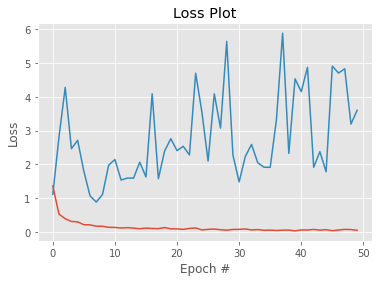

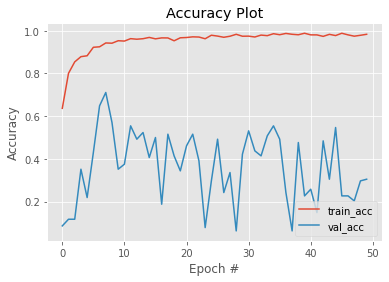

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

plt.plot(np.arange(0, 50), model_2.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), model_2.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

plt.plot(np.arange(0, 50), model_2.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 50), model_2.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

pred = model2.predict(test_gen)
predictions = np.argmax(pred, axis = 1)
# labels = (pred > 0.5).astype(np.int)
print(classification_report(test_gen.classes,predictions))

              precision    recall  f1-score   support

           0       1.00      0.41      0.59        58
           1       0.70      0.10      0.18       159
           2       0.71      1.00      0.83       428

    accuracy                           0.72       645
   macro avg       0.80      0.50      0.53       645
weighted avg       0.74      0.72      0.65       645

